# **Problem Statment:**

Analyze customer-level transactional data from ScalerMart to identify reasons behind their nearly 50% sales decline in 2020 compared to 2019.

# Step 1: Data Exploration and Cleaning
Data Cleaning Steps
- Load Data: Read the data from CSV files into Pandas DataFrames.
- Check for Missing Values: Identify and handle missing values.
- Check for Duplicates: Identify and remove duplicate records.
- Data Types Validation: Ensure columns have appropriate data types.
- Date Format Validation: Ensure date columns are in the correct format.
- Outlier Detection: Identify and handle outliers in the data.


In [3]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, chi2_contingency


In [4]:
# Load data
customers = pd.read_csv('Customers.csv', encoding='latin-1')
products = pd.read_csv('Products.csv')
sales = pd.read_csv('Sales.csv')

In [5]:
customers.head()

,CustomerKey,Gender,Name,City,State Code,State,Zip Code,Country,Continent,Birthday
0,301,Female,Lilly Harding,WANDEARAH EAST,SA,South Australia,5523,Australia,Australia,7/3/1939
1,325,Female,Madison Hull,MOUNT BUDD,WA,Western Australia,6522,Australia,Australia,9/27/1979
2,554,Female,Claire Ferres,WINJALLOK,VIC,Victoria,3380,Australia,Australia,5/26/1947
3,786,Male,Jai Poltpalingada,MIDDLE RIVER,SA,South Australia,5223,Australia,Australia,9/17/1957
4,1042,Male,Aidan Pankhurst,TAWONGA SOUTH,VIC,Victoria,3698,Australia,Australia,11/19/1965


In [6]:
products.head()

,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
0,1,Contoso 512MB MP3 Player E51 Silver,Contoso,Silver,$6.62,$12.99,101,MP4&MP3,1,Audio
1,2,Contoso 512MB MP3 Player E51 Blue,Contoso,Blue,$6.62,$12.99,101,MP4&MP3,1,Audio
2,3,Contoso 1G MP3 Player E100 White,Contoso,White,$7.40,$14.52,101,MP4&MP3,1,Audio
3,4,Contoso 2G MP3 Player E200 Silver,Contoso,Silver,$11.00,$21.57,101,MP4&MP3,1,Audio
4,5,Contoso 2G MP3 Player E200 Red,Contoso,Red,$11.00,$21.57,101,MP4&MP3,1,Audio


In [7]:
sales.head()

,Order Number,Line Item,Order Date,Delivery Date,CustomerKey,StoreKey,ProductKey,Quantity,Currency Code
0,366000,1,1/1/2016,NaN,265598,10,1304,1,CAD
1,366001,1,1/1/2016,1/13/2016,1269051,0,1048,2,USD
2,366001,2,1/1/2016,1/13/2016,1269051,0,2007,1,USD
3,366002,1,1/1/2016,1/12/2016,266019,0,1106,7,CAD
4,366002,2,1/1/2016,1/12/2016,266019,0,373,1,CAD


In [8]:
# Checking size and shape of the data
print(customers.shape)
print(products.shape)
print(sales.shape)

(15266, 10)
(2517, 10)
(62884, 9)


In [9]:
# Check for missing values
print(customers.isnull().sum())
print("-----------------------")
print(products.isnull().sum())
print("-----------------------")
print(sales.isnull().sum())
print("-----------------------")

CustomerKey     0
Gender          0
Name            0
City            0
State Code     10
State           0
Zip Code        0
Country         0
Continent       0
Birthday        0
dtype: int64
-----------------------
ProductKey        0
Product Name      0
Brand             0
Color             0
Unit Cost USD     0
Unit Price USD    0
SubcategoryKey    0
Subcategory       0
CategoryKey       0
Category          0
dtype: int64
-----------------------
Order Number         0
Line Item            0
Order Date           0
Delivery Date    49719
CustomerKey          0
StoreKey             0
ProductKey           0
Quantity             0
Currency Code        0
dtype: int64
-----------------------


**Insight:**

Some State codes are missing in Customers table we can replace those with mode, There are no missing values in Product table, Most of the delivery dates are missing in sales table.

**Handling missing values**

In [10]:
# Handling missing values in customer table with using mode.
customers['State Code'].fillna(customers['State'].mode()[0], inplace=True)
# Handling missing values in sales table by Order date
sales.fillna({'Delivery Date': sales['Order Date']}, inplace=True)

In [11]:
# Drop duplicates
customers.drop_duplicates(inplace=True)
products.drop_duplicates(inplace=True)
sales.drop_duplicates(inplace=True)

In [12]:
customers.info()
print("-------------------")
products.info()
print("-------------------")
sales.info()
print("-------------------")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15266 entries, 0 to 15265
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CustomerKey  15266 non-null  int64 
 1   Gender       15266 non-null  object
 2   Name         15266 non-null  object
 3   City         15266 non-null  object
 4   State Code   15266 non-null  object
 5   State        15266 non-null  object
 6   Zip Code     15266 non-null  object
 7   Country      15266 non-null  object
 8   Continent    15266 non-null  object
 9   Birthday     15266 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.2+ MB
-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ProductKey      2517 non-null   int64 
 1   Product Name    2517 non-null   object
 2   Brand           2517 non-null   object
 3

In [13]:
# Convert date columns to datetime
customers['Birthday'] = pd.to_datetime(customers['Birthday'], errors='coerce')
sales['Order Date'] = pd.to_datetime(sales['Order Date'], errors='coerce')
sales['Delivery Date'] = pd.to_datetime(sales['Delivery Date'], errors='coerce')

In [14]:
# checking unique values in all object columns in each table
print(customers.select_dtypes(include=['object']).nunique())
print("-------------------")
print(products.select_dtypes(include=['object']).nunique())
print("-------------------")
print(sales.select_dtypes(include=['object']).nunique())

Gender            2
Name          15118
City           8258
State Code      468
State           512
Zip Code       9505
Country           8
Continent         3
dtype: int64
-------------------
Product Name      2517
Brand               11
Color               16
Unit Cost USD      480
Unit Price USD     426
Subcategory         32
Category             8
dtype: int64
-------------------
Currency Code    5
dtype: int64


In [15]:
# Create age column
customers['Age']  = customers['Birthday'].apply(lambda x: 2024 - x.year)

In [16]:
# Merge Data
sales_customers = sales.merge(customers, on='CustomerKey', how='left')
sales_data = sales_customers.merge(products, on='ProductKey', how='left')


pd.options.display.max_columns = None

In [17]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62884 entries, 0 to 62883
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Order Number    62884 non-null  int64         
 1   Line Item       62884 non-null  int64         
 2   Order Date      62884 non-null  datetime64[ns]
 3   Delivery Date   62884 non-null  datetime64[ns]
 4   CustomerKey     62884 non-null  int64         
 5   StoreKey        62884 non-null  int64         
 6   ProductKey      62884 non-null  int64         
 7   Quantity        62884 non-null  int64         
 8   Currency Code   62884 non-null  object        
 9   Gender          62884 non-null  object        
 10  Name            62884 non-null  object        
 11  City            62884 non-null  object        
 12  State Code      62884 non-null  object        
 13  State           62884 non-null  object        
 14  Zip Code        62884 non-null  object        
 15  Co

In [18]:
# converting Unit cost USD annd Unit Price USD to float
sales_data["Unit Cost USD"] = sales_data["Unit Cost USD"].str.replace("$", "").str.strip().str.replace(",", "").astype(float)
sales_data["Unit Price USD"] = sales_data["Unit Price USD"].str.replace("$", "").str.strip().str.replace(",", "").astype(float)

**Data Exploration and Visualization**

In [19]:
sales_data.describe()

,Order Number,Line Item,Order Date,Delivery Date,CustomerKey,StoreKey,ProductKey,Quantity,Birthday,Age,Unit Cost USD,Unit Price USD,SubcategoryKey,CategoryKey
count,6.288400e+04,62884.000000,62884,62884,6.288400e+04,62884.000000,62884.000000,62884.000000,62884,62884.000000,62884.000000,62884.000000,62884.000000,62884.000000
mean,1.430905e+06,2.164207,2018-11-30 21:21:56.939126016,2018-12-01 20:07:20.582660352,1.180797e+06,31.802144,1125.859344,3.144790,1968-12-05 20:00:44.882641052,55.565613,116.253013,280.569848,450.198238,4.469611
min,3.660000e+05,1.000000,2016-01-01 00:00:00,2016-01-01 00:00:00,3.010000e+02,0.000000,1.000000,1.000000,1935-02-04 00:00:00,22.000000,0.480000,0.950000,101.000000,1.000000
25%,1.121017e+06,1.000000,2018-01-25 00:00:00,2018-01-27 00:00:00,6.808580e+05,8.000000,437.000000,1.000000,1952-02-11 00:00:00,39.000000,22.050000,47.950000,303.000000,3.000000
50%,1.498016e+06,2.000000,2019-02-06 00:00:00,2019-02-07 00:00:00,1.261200e+06,37.000000,1358.000000,2.000000,1968-11-09 00:00:00,56.000000,79.530000,181.000000,501.000000,5.000000
75%,1.788010e+06,3.000000,2019-11-23 00:00:00,2019-11-23 00:00:00,1.686496e+06,53.000000,1650.000000,4.000000,1985-09-24 00:00:00,72.000000,138.420000,300.000000,602.000000,6.000000
max,2.243032e+06,7.000000,2021-02-20 00:00:00,2021-02-27 00:00:00,2.099937e+06,66.000000,2517.000000,10.000000,2002-01-30 00:00:00,89.000000,1060.220000,3199.990000,808.000000,8.000000
std,4.532963e+05,1.365170,NaN,NaN,5.859634e+05,22.978188,709.244010,2.256371,NaN,19.408590,140.033327,382.827515,212.710652,2.132682


In [20]:
sales_data.describe(include = object)

,Currency Code,Gender,Name,City,State Code,State,Zip Code,Country,Continent,Product Name,Brand,Color,Subcategory,Category
count,62884,62884,62884,62884,62884,62884,62884,62884,62884,62884,62884,62884,62884,62884
unique,5,2,11783,6570,449,491,7771,8,3,2492,11,16,32,8
top,USD,Male,Gaspare Trevisan,Toronto,CA,California,90017,United States,North America,Adventure Works Desktop PC2.30 MD230 Black,Contoso,Black,Movie DVD,Computers
freq,33767,31804,36,683,3669,3629,317,33767,39182,162,15953,16539,9169,14025


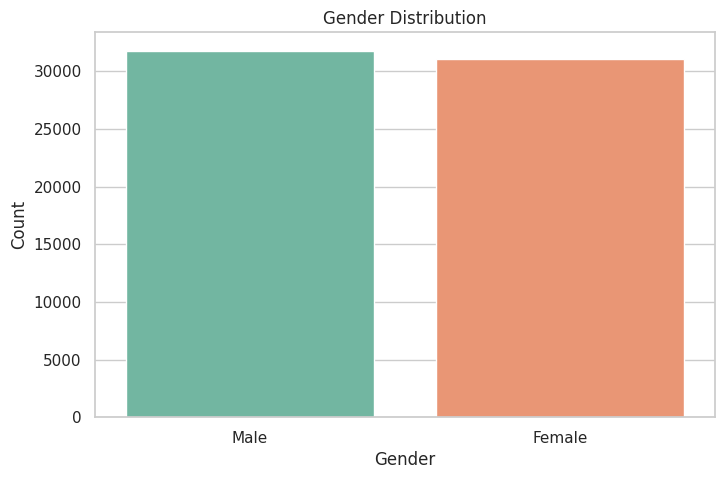

In [21]:
# igonre warnings
import warnings
warnings.filterwarnings('ignore')

# Gender distribution
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', data=sales_data, palette='Set2')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()

Insight: Gender distribution is uniform

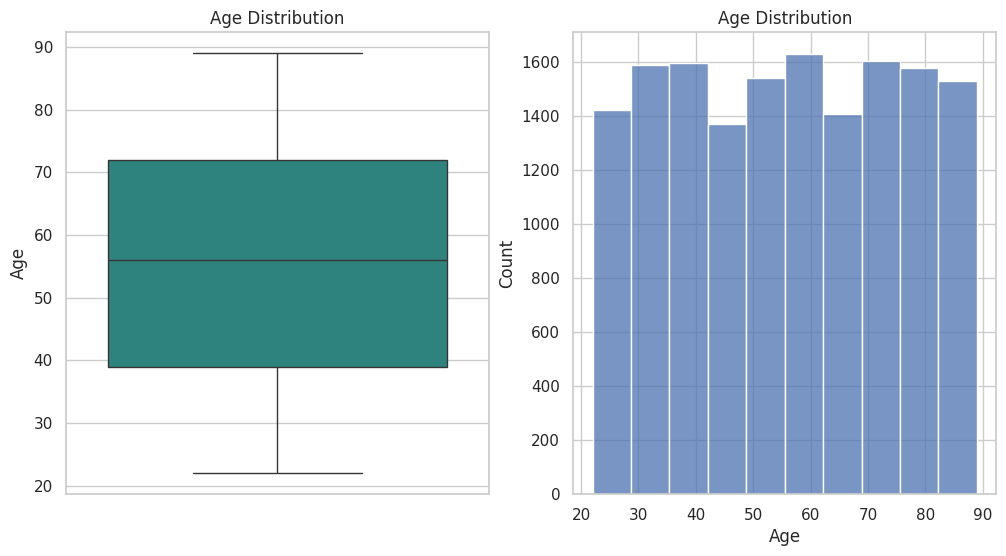

In [22]:
# Age distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
sns.histplot(customers['Age'], bins=10)
plt.title('Age Distribution')
plt.subplot(1, 2, 1)
sns.boxplot(customers['Age'], palette='viridis')
plt.title('Age Distribution')
plt.ylabel('Age')
plt.show()

Insight: Distribution of Age seems mostly uniform

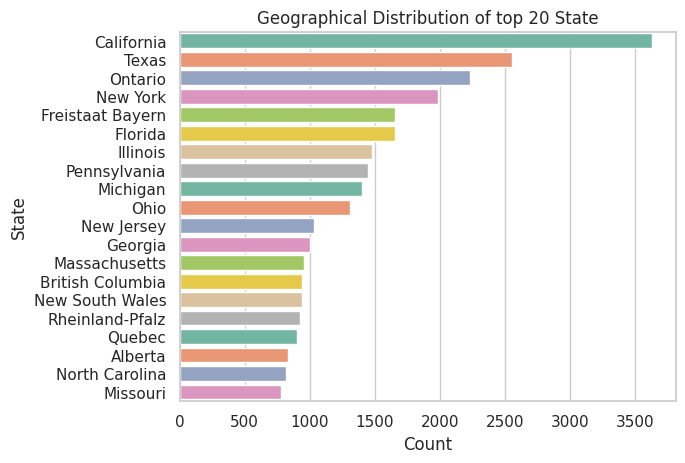

In [23]:
# Geographical distribution of top 20 states

sns.barplot(y = sales_data['State'].value_counts()[:20].index, x  = sales_data['State'].value_counts()[:20].values, palette='Set2')
plt.xlabel('Count')
plt.ylabel('State')
plt.title('Geographical Distribution of top 20 State')
plt.show()

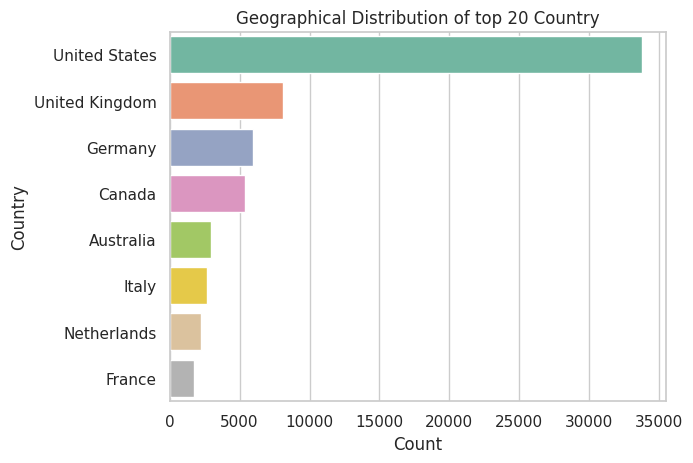

In [24]:
# Geographical distribution by Country
sns.barplot(y = sales_data['Country'].value_counts()[:20].index, x  = sales_data['Country'].value_counts()[:20].values, palette='Set2')
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Geographical Distribution of top 20 Country')
plt.show()

Insight: Most of the sales are from United Stats within which state of California

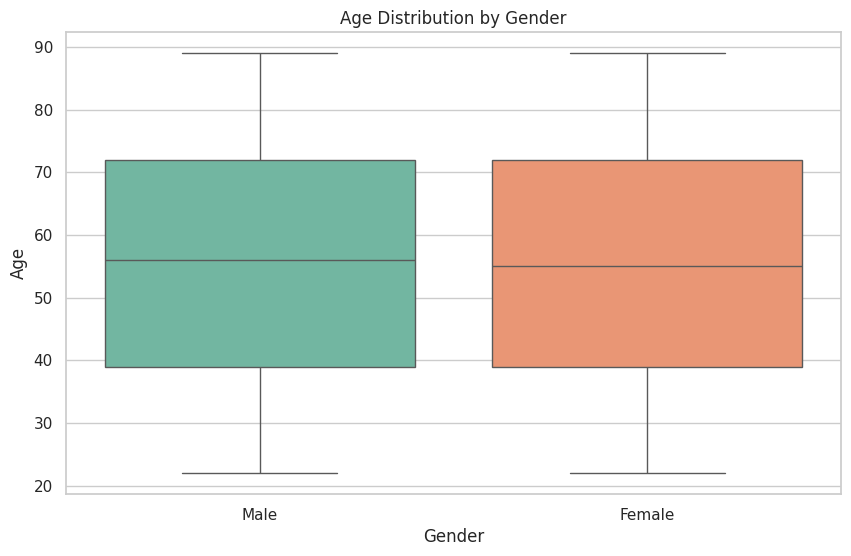

In [25]:
# Age distribution by Gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Age', data=sales_data, palette  = "Set2")
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

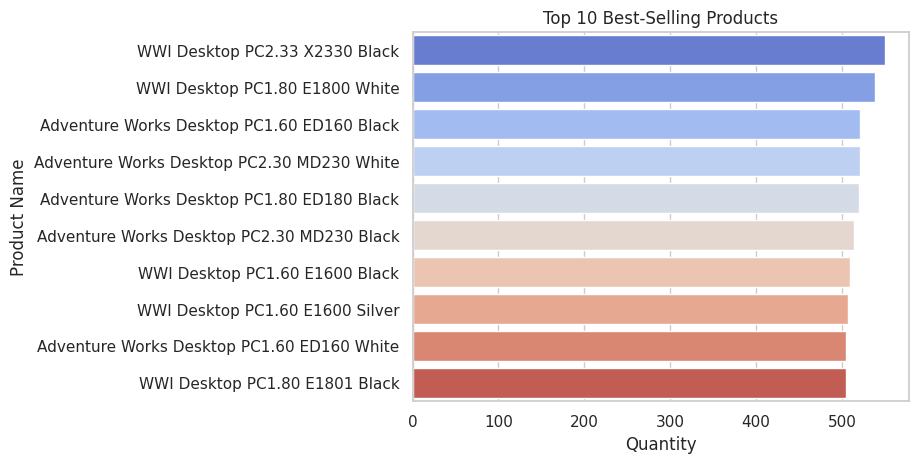

In [26]:
# Best-Selling Products
top_products = sales_data.groupby('ProductKey')['Quantity'].sum().nlargest(10).reset_index()
top_products = top_products.merge(products, on='ProductKey')

sns.barplot(x='Quantity', y='Product Name', data=top_products, palette = "coolwarm")
plt.title('Top 10 Best-Selling Products')
plt.show()

Insights: Quantity of computer sales is highest

Price sensitivity is the degree to which demand changes when the cost of a product or service changes.

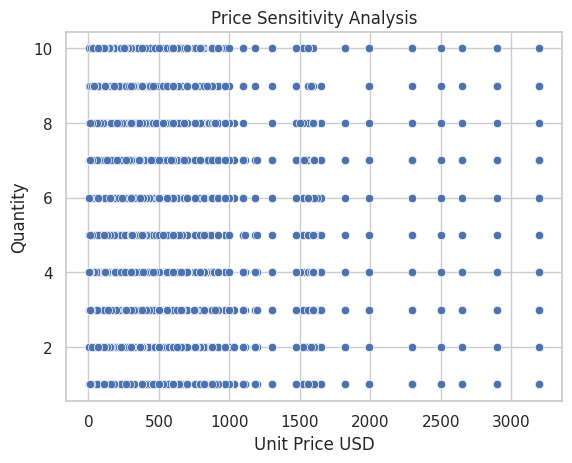

In [27]:
# Price Sensitivity Analysis
sns.scatterplot(x='Unit Price USD', y='Quantity', data=sales_data, palette='coolwarm')
plt.title('Price Sensitivity Analysis')
plt.show()

Insights: the scatterplot suggests a possible negative correlation between price and quantity, but it's not a very strong effect.



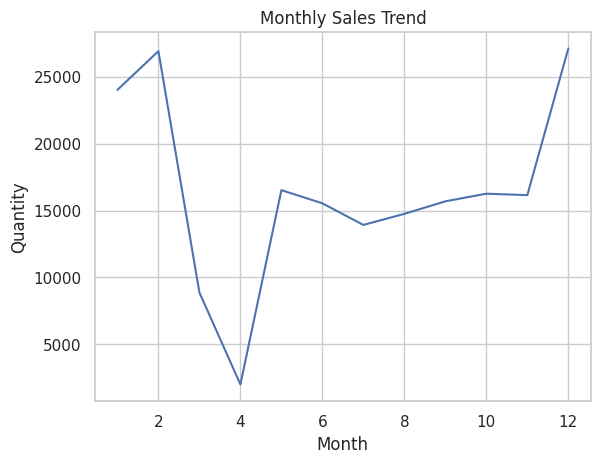

In [28]:
# Seasonality Analysis
sales_data['Month'] = sales_data['Order Date'].dt.month
monthly_sales = sales_data.groupby('Month')['Quantity'].sum().reset_index()
sns.lineplot(x='Month', y='Quantity', data=monthly_sales)
plt.title('Monthly Sales Trend')
plt.show()

Insights:
- The overall trend seems to be upward, indicating increasing sales over the months displayed on the horizontal axis.
- It's difficult to definitively determine seasonality from just one year of data.

In [29]:
# Creating amount column by multiplying quantity and unit price
sales_data['Amount'] = sales_data['Quantity'] * sales_data['Unit Price USD']


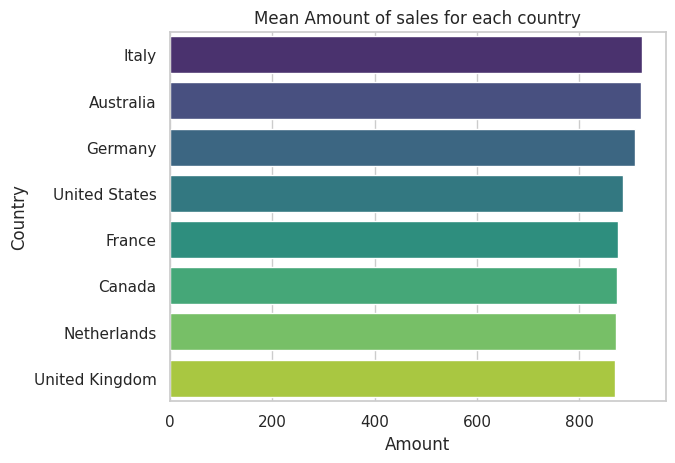

In [30]:
# plotting Amount of sales for each country
sns.barplot(y = sales_data.groupby("Country")["Amount"].mean().index[np.argsort(sales_data.groupby("Country")["Amount"].mean().values)[::-1]],
            x = np.sort(sales_data.groupby("Country")["Amount"].mean().values)[::-1], palette='viridis')
plt.xlabel('Amount')
plt.ylabel('Country')
plt.title('Mean Amount of sales for each country')
plt.show()



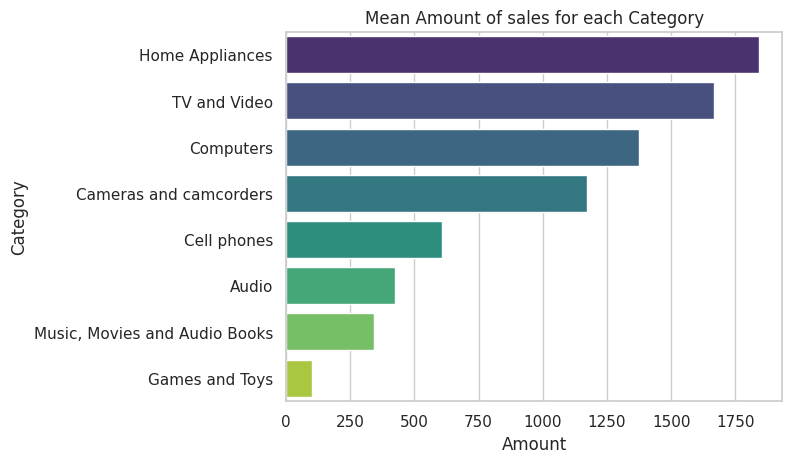

In [31]:
# plotting Amount of sales for each category
sns.barplot(y = sales_data.groupby("Category")["Amount"].mean().index[np.argsort(sales_data.groupby("Category")["Amount"].mean().values)[::-1]],
            x = np.sort(sales_data.groupby("Category")["Amount"].mean().values)[::-1], palette='viridis')
plt.xlabel('Amount')
plt.ylabel('Category')
plt.title('Mean Amount of sales for each Category')
plt.show()


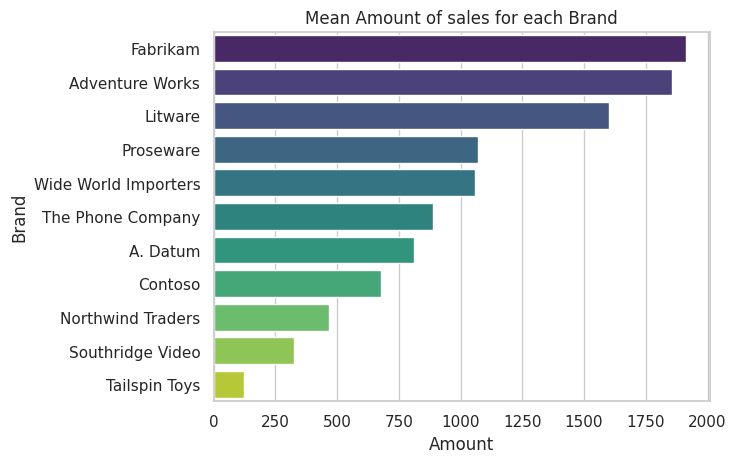

In [32]:
# plotting Amount of sales for each Brand
sns.barplot(y = sales_data.groupby("Brand")["Amount"].mean().index[np.argsort(sales_data.groupby("Brand")["Amount"].mean().values)[::-1]],
            x = np.sort(sales_data.groupby("Brand")["Amount"].mean().values)[::-1], palette='viridis')
plt.xlabel('Amount')
plt.ylabel('Brand')
plt.title('Mean Amount of sales for each Brand')
plt.show()


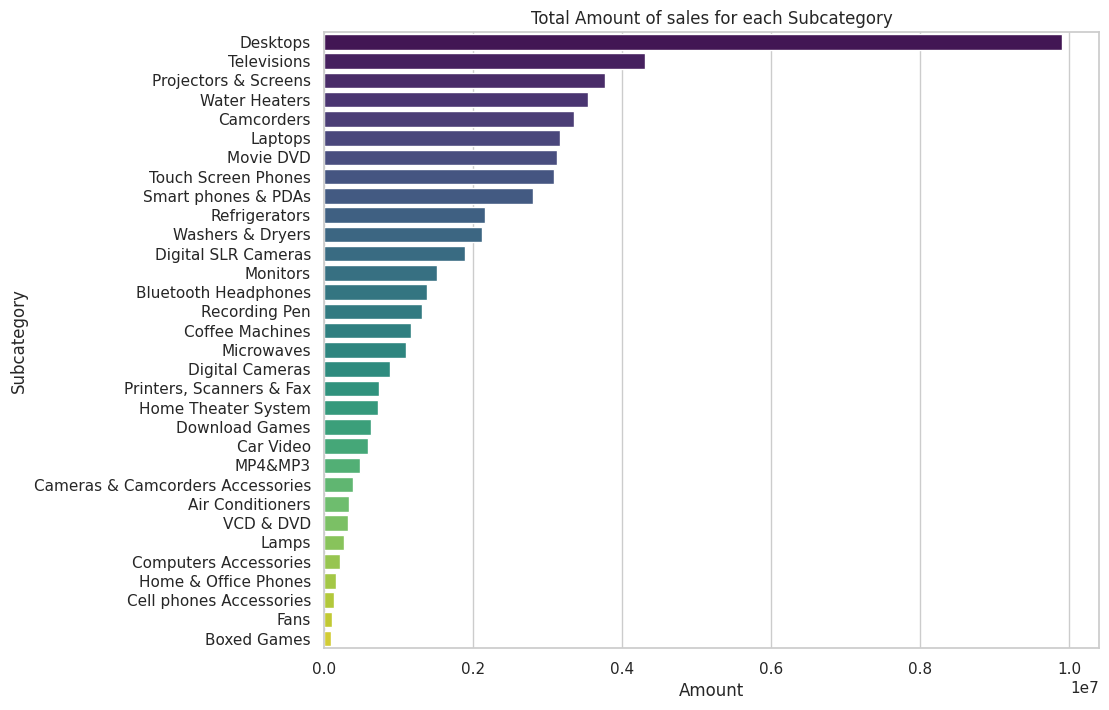

In [33]:
# plotting Amount of sales for each Subcategory

plt.figure(figsize=(10, 8))
sns.barplot(y = sales_data.groupby("Subcategory")["Amount"].sum().index[np.argsort(sales_data.groupby("Subcategory")["Amount"].sum().values)][::-1],
            x = np.sort(sales_data.groupby("Subcategory")["Amount"].sum().values)[::-1], palette='viridis')
plt.xlabel('Amount')
plt.ylabel('Subcategory')
plt.title('Total Amount of sales for each Subcategory')
plt.show()


Order Date
2016     6946793.56
2017     7421422.27
2018    12788960.66
2019    18264382.48
2020     9294632.14
2021     1039288.48
Freq: A-DEC, Name: Amount, dtype: float64


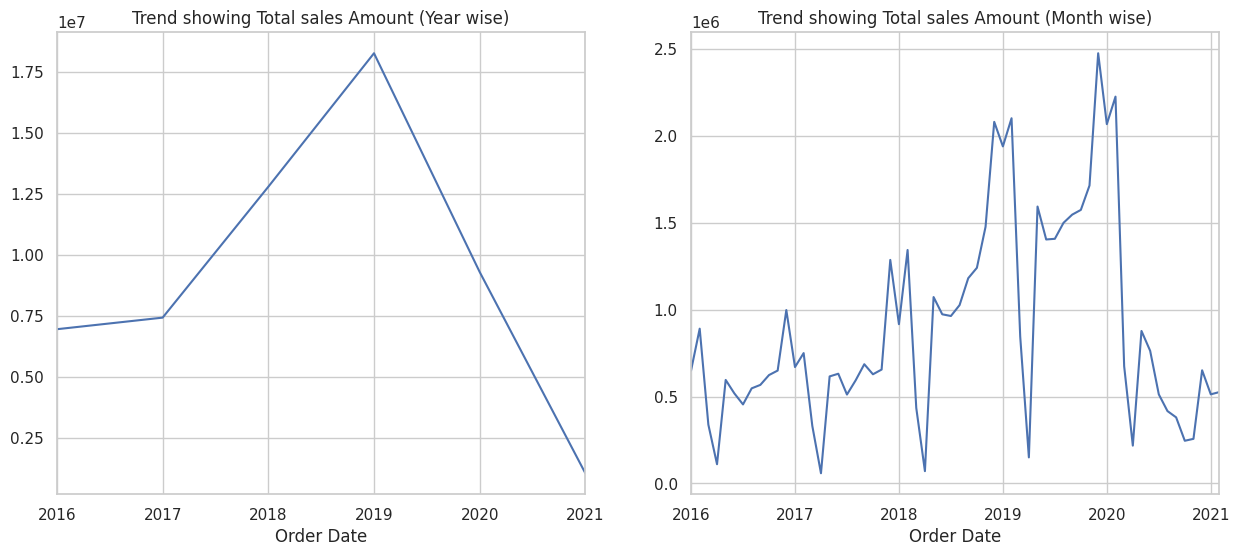

In [34]:
# plotting trend showing avg sales Amount by order date

df = sales_data[["Order Date", "Amount"]]
print(df.groupby(df['Order Date'].dt.to_period('Y'))["Amount"].sum())
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
df.groupby(df['Order Date'].dt.to_period('Y'))["Amount"].sum().plot()
plt.title('Trend showing Total sales Amount (Year wise)')

plt.subplot(1,2,2)
df.groupby(df['Order Date'].dt.to_period('M'))["Amount"].sum().plot()
plt.title('Trend showing Total sales Amount (Month wise)')


plt.show()

Insight: There is significant drop in Sales from year 2019-20  to 2020 - 21

# Step 2: User Segmentation

Recommended Customer Segmentation Techniques -

**RFM Analysis:**

- It is effective for understanding customer value based on Recency (R), Frequency (F), and Monetary (M) metrics. It helps in identifying high-value customers, loyal customers, and those at risk of churn.
- It can be done by scoring customers on their purchase recency, frequency, and monetary value and grouping them into segments.


**K-Means Clustering:**

- It is a popular and straightforward method for grouping customers into distinct segments based on multiple features such as age, gender, location, and purchase behavior.
- It can be done by minimizing the variance within clusters and maximizing the variance between clusters.

**Why is segmentation crucial for this analysis?**

- **Targeted Marketing:** Enables personalized marketing strategies tailored to different customer groups.
- **Resource Allocation:** Helps in prioritizing marketing efforts and resources on the most valuable customer segments.
- **Customer Retention:** Identifies at-risk customers who can be targeted with retention campaigns.
- **Product Development:** Provides insights into customer preferences and behavior, aiding in product development and inventory management.



**1. Segmentation Using RFM Analysis**

In [35]:
# Prepare RFM data
rfm = sales_data.groupby('CustomerKey').agg({
    'Order Date': lambda x: (pd.Timestamp.now() - x.max()).days,
    'Order Number': 'count',
    'Amount': 'mean'
}).rename(columns={'Order Date': 'Recency', 'Order Number': 'Frequency', 'Amount': 'Monetary'})

In [36]:
# Segment customers into quantiles
rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, ['1', '2', '3', '4'])
rfm['F_Quartile'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, ['4', '3', '2', '1'])
rfm['M_Quartile'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, ['4', '3', '2', '1'])

# Calculate RFM Score
rfm['RFM_Score'] = rfm['R_Quartile'].astype(str) + rfm['F_Quartile'].astype(str) + rfm['M_Quartile'].astype(str)

# Define customer segments
def segment_customer(df):
    if df['RFM_Score'] == '111':
        return 'Best Customers'
    elif df['RFM_Score'].startswith('1'):
        return 'Loyal Customers'
    elif df['RFM_Score'].endswith('1'):
        return 'Big Spenders'
    elif df['RFM_Score'].startswith('4'):
        return 'At Risk Customers'
    elif df['RFM_Score'].endswith('4'):
        return 'Lost Customers'
    elif df['RFM_Score'][0] == '1' and df['RFM_Score'][1] in ['2', '3']:
        return 'Potential Loyalists'
    elif df['RFM_Score'][0] == '2' and df['RFM_Score'][1] in ['1', '2']:
        return 'New Customers'
    elif df['RFM_Score'][0] == '3' and df['RFM_Score'][1] in ['1', '2']:
        return 'Promising'
    elif df['RFM_Score'][0] == '4' and df['RFM_Score'][1] in ['2', '3']:
        return 'Need Attention'
    elif df['RFM_Score'][0] == '4' and df['RFM_Score'][1] == '4':
        return 'At Risk'
    elif df['RFM_Score'][0] == '3' and df['RFM_Score'][1] == '4':
        return 'About to Sleep'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

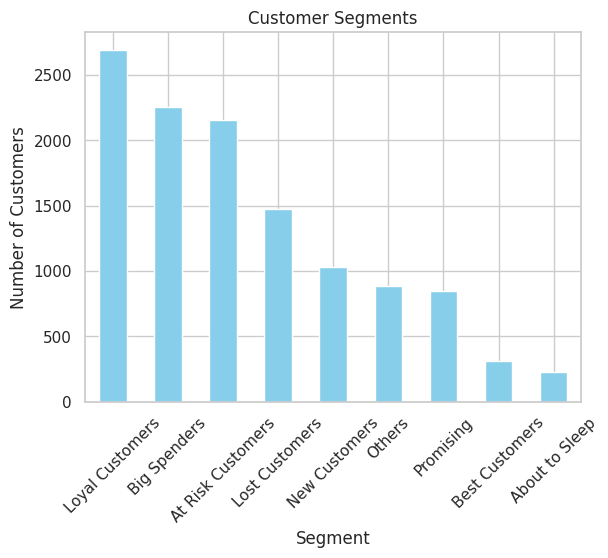

In [37]:
#  Analyze purchase patterns within each segment and Visualizing the segments
rfm_segment_analysis = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).sort_values(by='Monetary', ascending=False)

rfm['Segment'].value_counts().plot(kind='bar', color = 'skyblue')
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.xticks(rotation = 45)
plt.ylabel('Number of Customers')
plt.show()

Insights:

- Loyal Customers (23%): Focus on retention with loyalty programs, upselling, and exceptional service.
- Promising Customers (19%): Nurture with targeted campaigns and incentives to increase purchase frequency or value.
- At-Risk Customers (18%): Win them back with special offers and address reasons for decline.
- Lost Customers (12%): Reactivate with targeted campaigns and understand why they left.
- New Customers (8%): Welcome them and encourage repeat purchases with special offers or loyalty programs.


In [38]:
sales_data = sales_data.merge(rfm, on = "CustomerKey", how  = "left").drop(columns= ["Recency", "Frequency", "Monetary", "R_Quartile", "F_Quartile", "M_Quartile"])

# Step 3: Engagement Analysis

To perform an engagement analysis, we need to devise a metric to quantify customer loyalty and analyze trends over time. We will also correlate user demographics with purchase behavior and perform hypothesis testing to identify statistically significant relationships.

- A common metric to quantify customer loyalty is the Repeat Purchase Rate (RPR).
This metric measures the proportion of customers who make repeat purchases within a given period.

In [114]:
sales_customers = sales_data.copy()

# Repeat Purchase Rate
repeat_customers = sales_customers[sales_customers.duplicated(['CustomerKey'], keep=False)]
repeat_purchase_rate = repeat_customers['CustomerKey'].nunique() / sales_customers['CustomerKey'].nunique()
print(f'Repeat Purchase Rate: {repeat_purchase_rate}')

Repeat Purchase Rate: 0.8675023134516698


Insights: Repeat purchase rate is 86.7%

In [132]:
# Analyze trends over time
repeat_customers['YearMonth'] = repeat_customers['Order Date'].dt.to_period('M')
sales_customers['YearMonth'] = sales_customers['Order Date'].dt.to_period('M')

monthly_repeat_purchases = repeat_customers.groupby('YearMonth')['Order Number'].count().reset_index()
monthly_total_purchases = sales_customers.groupby('YearMonth')['Order Number'].count().reset_index()

# Calculate monthly Repeat Purchase Rate
monthly_repeat_purchases = monthly_repeat_purchases.rename(columns={'Order Number': 'Repeat Orders'})
monthly_total_purchases = monthly_total_purchases.rename(columns={'Order Number': 'Total Orders'})

monthly_repeat_rate = pd.merge(monthly_repeat_purchases, monthly_total_purchases, on='YearMonth')
monthly_repeat_rate['Repeat Purchase Rate'] = monthly_repeat_rate['Repeat Orders'] / monthly_repeat_rate['Total Orders']

monthly_repeat_rate['YearMonth'] = monthly_repeat_rate['YearMonth'].dt.to_timestamp()

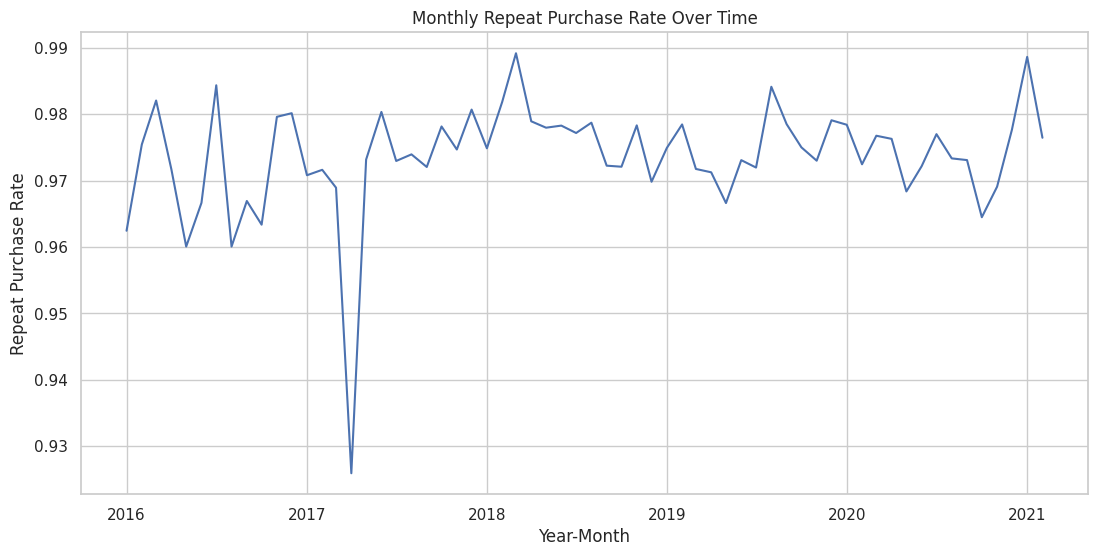

In [133]:
# Plot the Repeat Purchase Rate over time
plt.figure(figsize=(13, 6))
sns.lineplot(x = "YearMonth", y = 'Repeat Purchase Rate', data = monthly_repeat_rate)
plt.title('Monthly Repeat Purchase Rate Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Repeat Purchase Rate')
plt.show()

**Formulate and Test Hypotheses**

To identify statistically significant relationships, we can formulate and test hypotheses using statistical tests such as t-tests or chi-squared tests.

Hypothesis 1:

Null Hypothesis (H0): There is no significant difference in purchase Amount between male and female customers.

Alternative Hypothesis (H1): There is a significant difference in purchase Amount between male and female customers.

In [141]:
from scipy.stats import ttest_ind

# Hypothesis Testing: Gender and Purchase Quantity
male_amount = sales_data[sales_data['Gender'] == 'Male']['Amount']
female_amount = sales_data[sales_data['Gender'] == 'Female']['Amount']

# Perform t-test
t_stat, p_value = ttest_ind(male_amount, female_amount, equal_var=False)
print(f't-statistic: {t_stat}, p-value: {p_value}')

# Conclusion
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in purchase Amount between male and female customers.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in purchase Amount between male and female customers.")


t-statistic: 0.6589033306715538, p-value: 0.5099602596207471
Fail to reject the null hypothesis: There is no significant difference in purchase quantity between male and female customers.


Hypothesis 2:

Null Hypothesis (H0): There is no significant correlation between the age of customers and the amount they spend.

Alternative Hypothesis (H1): There is a significant correlation between the age of customers and the amount they spend.

In [146]:
from scipy.stats import spearmanr
# Calculate Spearman correlation
age_amount_corr, p_value = spearmanr(sales_customers['Age'], sales_customers['Amount'])
print(f'Spearman Correlation between Age and Amount: {age_amount_corr}')
print(f'p-value: {p_value}')

# Hypothesis Testing
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant correlation between the age of customers and the amount they spend.")
else:
    print("Fail to reject the null hypothesis: There is no significant correlation between the age of customers and the amount they spend.")


Spearman Correlation between Age and Amount: 0.0037177968425968107
p-value: 0.35118936320497607
Fail to reject the null hypothesis: There is no significant correlation between the age of customers and the amount they spend.


Hypothesis 3:

Null Hypothesis (H0): There is no significant difference in the amount spent across different continents.

Alternative Hypothesis (H1): There is a significant difference in the amount spent across different continents.

To implement the One-way ANOVA test, we need to make sure that they are satisfying certain
 conditions:
 1. Data should be normally distributed (i.e, Gaussian)
 2. Data should be independent across each record
 3. Equal variance in different groups

In [163]:
North_America = np.random.choice(sales_data[sales_data['Continent'] == 'North America']["Amount"], size = 200)
Europe = np.random.choice(sales_data[sales_data['Continent'] == 'Europe']["Amount"], size = 200)
Australia = np.random.choice(sales_data[sales_data['Continent'] == 'Australia']["Amount"], size = 200)

from scipy.stats import shapiro

test_stat, p_value = shapiro(Australia)
print(p_value)

if p_value < 0.05:
 print("Data is not Gaussian")
else:
 print("Data is Gaussian")


2.4256838818570256e-19
Data is not Gaussian


With Shapiro wilker test we found out data is not gaussian, we will perform kruskal wallis test

p-value: 0.8214589865690228
Fail to reject the null hypothesis: There is no significant difference in the amount spent across different continents.


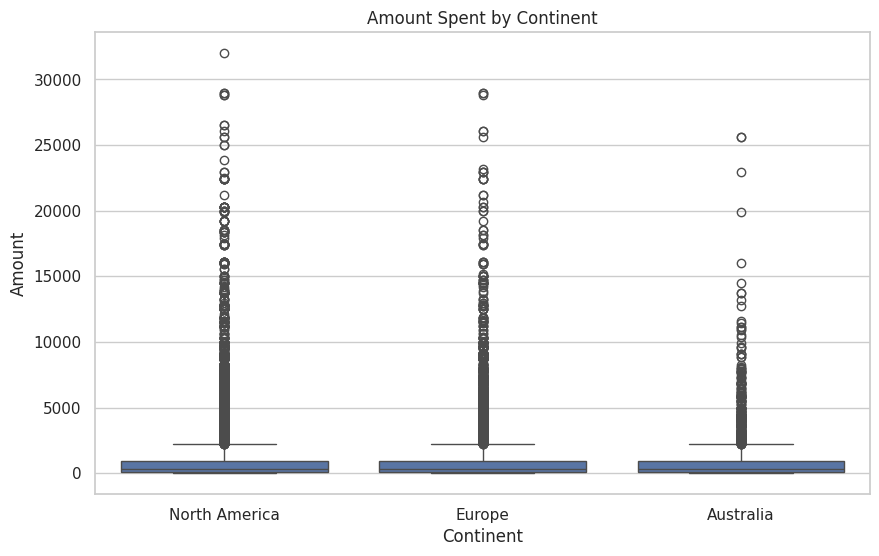

In [184]:
from scipy.stats import kruskal

North_America = sales_data[sales_data['Continent'] == 'North America']["Amount"]
Europe = sales_data[sales_data['Continent'] == 'Europe']["Amount"]
Australia = sales_data[sales_data['Continent'] == 'Australia']["Amount"]


# Perform Kruskal-Wallis Test
stat, p_value = kruskal(North_America, Europe, Australia)

print(f'p-value: {p_value}')

# Hypothesis Testing
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in the amount spent across different continents.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the amount spent across different continents.")

# Visualize the Amount spent across Continents
plt.figure(figsize=(10, 6))
sns.boxplot(x='Continent', y='Amount', data=sales_data)
plt.title('Amount Spent by Continent')
plt.xlabel('Continent')
plt.ylabel('Amount')
plt.show()

Kruskal-Wallis H-statistic: 4142.061491155014
p-value: 0.0
Reject the null hypothesis: There is a significant difference in the amount spent among different RFM segments.


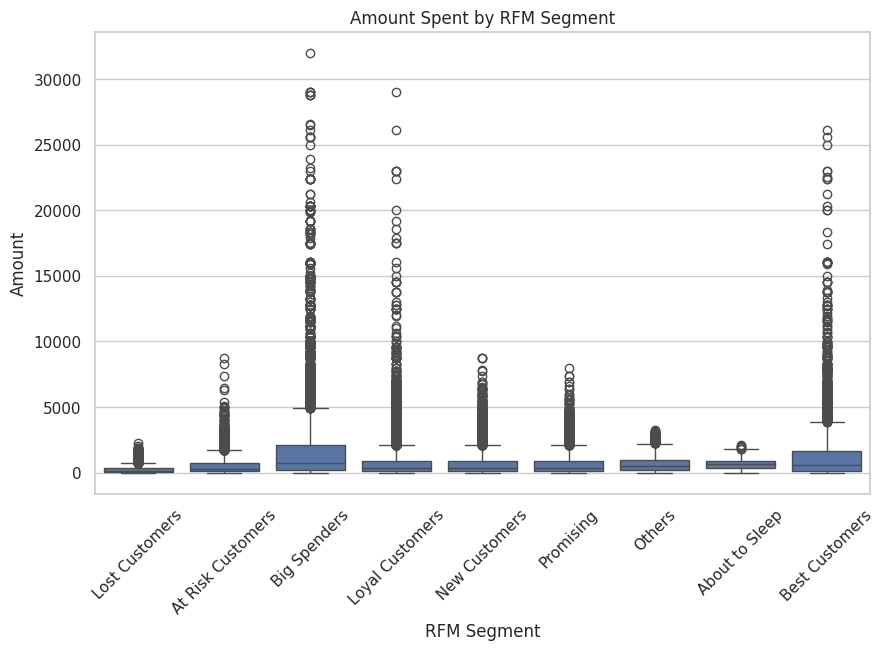

In [185]:
# Group data by Segment
grouped_data = [group['Amount'].values for name, group in sales_data.groupby('Segment')]

# Perform Kruskal-Wallis Test
stat, p_value = kruskal(*grouped_data)
print(f'Kruskal-Wallis H-statistic: {stat}')
print(f'p-value: {p_value}')

# Hypothesis Testing
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in the amount spent among different RFM segments.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the amount spent among different RFM segments.")

# Visualize the Amount spent by RFM Segment
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='Amount', data=sales_customers)
plt.title('Amount Spent by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.show()

Insights: There is a significant difference in the amount spent among different RFM segments.

<Axes: xlabel='Country'>

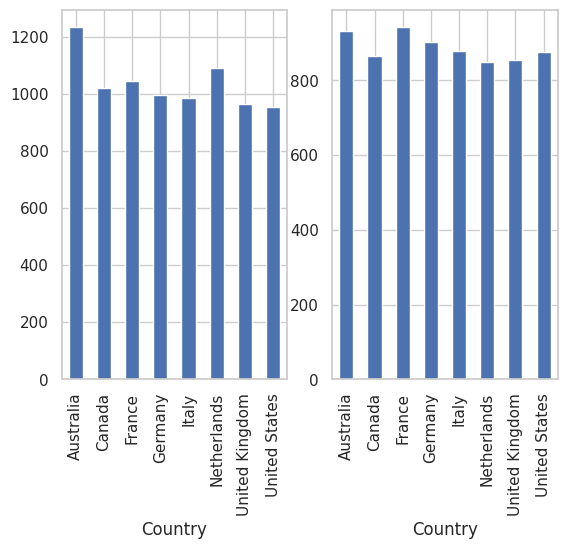

In [236]:
pruning_customers = ["Lost Customers", "At Risk Customers", "Others", "About to Sleep"]
df_temp1 = sales_data[~sales_data['Segment'].isin(pruning_customers)][["Country", "Amount", "Order Date"]]

data_2019 = df_temp1[df_temp1["Order Date"].dt.year == 2019]
data_2020 = df_temp1[(df_temp1["Order Date"].dt.year == 2020) | (df_temp1["Order Date"].dt.year == 2021)]

plt.subplot(1,2,1)
data_2019.groupby("Country")["Amount"].mean().plot(kind="bar")
plt.subplot(1,2,2)
data_2020.groupby("Country")["Amount"].mean().plot(kind="bar")

In [237]:
from scipy.stats import ttest_ind


for country in sales_data.Country.unique():

  # Hypothesis Testing: Gender and Purchase Quantity
  data_2019_amount = data_2019[data_2019['Country'] == country]['Amount']
  data_2020_amount = data_2020[data_2020['Country'] == country]['Amount']

  # Perform t-test
  t_stat, p_value = ttest_ind(data_2019_amount, data_2020_amount, equal_var=False)

  # Conclusion
  if p_value < 0.05:
      print(f"Reject the null hypothesis: There is a significant difference in purchase Amount between 2019 {country} sales and 2020 {country} sales .")

Reject the null hypothesis: There is a significant difference in purchase Amount between 2019 Canada sales and 2020 Canada sales .
Reject the null hypothesis: There is a significant difference in purchase Amount between 2019 United States sales and 2020 United States sales .
Reject the null hypothesis: There is a significant difference in purchase Amount between 2019 Netherlands sales and 2020 Netherlands sales .
Reject the null hypothesis: There is a significant difference in purchase Amount between 2019 Australia sales and 2020 Australia sales .


Insights: Sales from United States, Canada, Netherlands, Australia are reduced from 2019 to 2020-21.

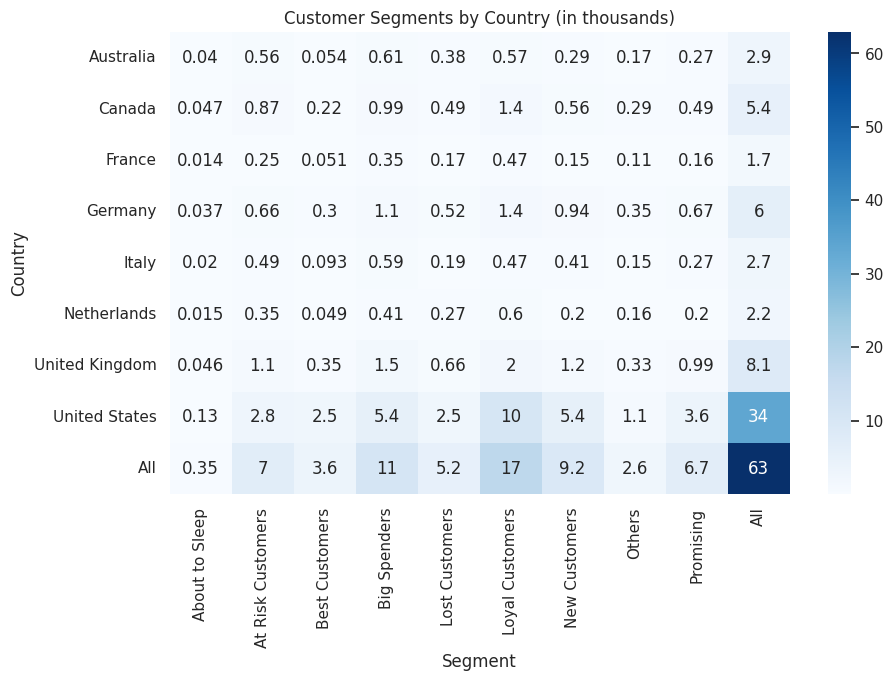

In [251]:
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(sales_data["Country"], sales_data["Segment"], margins = True)/1000, cmap = 'Blues', annot = True)
plt.title('Customer Segments by Country (in thousands)')
plt.show()


Insights: most of the sales are from United States, followed by UK.

# Step 4: Recommendations

**Potential Explanations for the Decline in Sales Economic Downturn:**

- The analysis shows a significant drop in sales from 2019 to 2020. This could be due to the economic impact of the COVID-19 pandemic, leading to reduced consumer spending.

**Customer Churn:**

- The segmentation analysis identified a substantial number of "Lost Customers" and "At Risk Customers." These segments indicate customers who have either stopped purchasing or are on the verge of churn.

**Seasonal Effects:**

- The monthly sales trend shows fluctuations, which could be due to seasonal effects. The lack of consistent promotional campaigns during peak seasons might have contributed to the decline.

**Product Issues:**

- The price sensitivity analysis suggests a negative correlation between price and quantity, indicating that higher prices might be deterring customers from purchasing more.

**Geographical Concentration:**

- The geographical analysis indicates that most sales are concentrated in the United States, particularly in California. Over-reliance on a specific region may have affected overall sales when that region's economy was impacted.
Recommendations to Improve Sales

**Enhance Customer Retention Programs:**

- Loyalty Programs: Implement and enhance loyalty programs to reward repeat purchases. Provide personalized discounts and offers to loyal customers to increase their lifetime value.

- Reactivation Campaigns: Target "Lost Customers" and "At Risk Customers" with reactivation campaigns. Offer special promotions and incentives to encourage them to return.

**Dynamic Pricing Strategies:**

- Implement dynamic pricing strategies based on demand and competitor pricing. Use price elasticity analysis to determine optimal pricing that maximizes sales volume without sacrificing profit margins.

**Seasonal Promotions:**

- Launch targeted promotional campaigns during peak seasons. Use historical sales data to identify high-sales periods and plan marketing campaigns accordingly.

**Geographical Expansion:**

- Diversify the customer base by expanding marketing efforts to other regions and countries. Use targeted advertising to reach potential customers in underrepresented areas.

**Product Portfolio Optimization:**

- Analyze product performance and discontinue low-performing products. Focus on promoting best-selling products and expanding the product line with similar high-demand items.

**Customer Feedback Loop:**

- Establish a robust customer feedback mechanism to continuously gather insights on customer preferences and pain points. Use this feedback to improve products and services.


**RFM-Based Marketing:**

- Utilize RFM (Recency, Frequency, Monetary) analysis to segment customers and tailor marketing strategies. For example:

- Best Customers: Upsell and cross-sell premium products.
- Promising Customers: Offer incentives to increase purchase frequency.
- New Customers: Provide a welcoming experience and encourage repeat purchases with introductory offers.